# Gibbs textural filters comparison on BRATS data

We compare the performance of models trained on stylized datasets on differently stylized datasets.



The dataset comes from http://medicaldecathlon.com/.  
Target: Gliomas segmentation necrotic/active tumour and oedema  
Modality: Multimodal multisite MRI data (FLAIR, T1w, T1gd,T2w)  
Size: 750 4D volumes (484 Training + 266 Testing)  
Source: BRATS 2016 and 2017 datasets.  
Challenge: Complex and heterogeneously-located targets

Below figure shows image patches with the tumor sub-regions that are annotated in the different modalities (top left) and the final labels for the whole dataset (right).
(Figure taken from the [BraTS IEEE TMI paper](https://ieeexplore.ieee.org/document/6975210/))

![image](../figures/brats_tasks.png)

The image patches show from left to right:
1. the whole tumor (yellow) visible in T2-FLAIR (Fig.A).
1. the tumor core (red) visible in T2 (Fig.B).
1. the enhancing tumor structures (light blue) visible in T1Gd, surrounding the cystic/necrotic components of the core (green) (Fig. C).
1. The segmentations are combined to generate the final labels of the tumor sub-regions (Fig.D): edema (yellow), non-enhancing solid core (red), necrotic/cystic core (green), enhancing core (blue).

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/tutorials/blob/master/3d_segmentation/brats_segmentation_3d.ipynb)

## Setup imports

In [1]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.networks.nets import UNet
from monai.transforms import (
    Activations,
    AsChannelFirstd,
    AsDiscrete,
    CenterSpatialCropd,
    Compose,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    ToTensord,
)
from monai.utils import set_determinism

import torch
from torch.utils.data import random_split
from tqdm import tqdm

############################################
# Local imports

SOURCE_CODE_PATH = '/homes/yc7620/Documents/medical-vision-textural-bias/90_source_code/'
import sys
sys.path.append(SOURCE_CODE_PATH)

from filters_and_operators import RandPlaneWaves_ellipsoid
from utils import show_slice_and_fourier
#############################################

# set determinism for reproducibility
set_determinism(seed=0)


root_dir = '/vol/bitbucket/yc7620/90_data/52_MONAI_DATA_DIRECTORY/'
print('root_dir', root_dir)
print_config()

device = torch.device("cuda:0")

root_dir /vol/bitbucket/yc7620/90_data/52_MONAI_DATA_DIRECTORY/
MONAI version: 0.5.dev2113
Numpy version: 1.19.2
Pytorch version: 1.8.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: b3cc668c924b2a7e6b822416f4d920a098c27704

Optional dependencies:
Pytorch Ignite version: 0.4.4
Nibabel version: 3.2.1
scikit-image version: 0.17.2
Pillow version: 8.1.2
Tensorboard version: 1.15.0
gdown version: 3.12.2
TorchVision version: 0.9.0
ITK version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.50.2
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Define a new transform to convert brain tumor labels

Here we convert the multi-classes labels into multi-labels segmentation task in One-Hot format.

In [2]:
class ConvertToMultiChannelBasedOnBratsClassesd(MapTransform):
    """
    Convert labels to multi channels based on brats classes:
    label 1 is the peritumoral edema
    label 2 is the GD-enhancing tumor
    label 3 is the necrotic and non-enhancing tumor core
    The possible classes are TC (Tumor core), WT (Whole tumor)
    and ET (Enhancing tumor).

    """

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            result = []
            # merge label 2 and label 3 to construct TC
            result.append(np.logical_or(d[key] == 2, d[key] == 3))
            # merge labels 1, 2 and 3 to construct WT
            result.append(
                np.logical_or(
                    np.logical_or(d[key] == 2, d[key] == 3), d[key] == 1
                )
            )
            # label 2 is ET
            result.append(d[key] == 2)
            d[key] = np.stack(result, axis=0).astype(np.float32)
        return d

## Setup transforms for each dataset

Here we vary the amplitude of the plane waves while holding the sampling ellipsoid constant with (a,b,c) = (55,55,30).

In [3]:
val_transform_baseline = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AsChannelFirstd(keys="image"),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        CenterSpatialCropd(keys=["image", "label"], roi_size=[128, 128, 64]),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        ToTensord(keys=["image", "label"])
    ]
)

val_transform_planes12 = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AsChannelFirstd(keys="image"),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        CenterSpatialCropd(keys=["image", "label"], roi_size=[128, 128, 64]),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        ToTensord(keys=["image", "label"]),
        RandPlaneWaves_ellipsoid('image',55.,55.,30., intensity_value=12, prob=1.)
    ]
)

val_transform_planes14 = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AsChannelFirstd(keys="image"),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        CenterSpatialCropd(keys=["image", "label"], roi_size=[128, 128, 64]),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        ToTensord(keys=["image", "label"]),
        RandPlaneWaves_ellipsoid('image',55.,55.,30., intensity_value=14, prob=1.)
    ]
)

val_transform_planes15 = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AsChannelFirstd(keys="image"),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        CenterSpatialCropd(keys=["image", "label"], roi_size=[128, 128, 64]),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        ToTensord(keys=["image", "label"]),
        RandPlaneWaves_ellipsoid('image',55.,55.,30., intensity_value=15, prob=1.)
    ]
)

val_transform_planes16 = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AsChannelFirstd(keys="image"),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        CenterSpatialCropd(keys=["image", "label"], roi_size=[128, 128, 64]),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        ToTensord(keys=["image", "label"]),
        RandPlaneWaves_ellipsoid('image',55.,55.,30., intensity_value=16, prob=1.)
    ]
)

val_transform_planes16 = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AsChannelFirstd(keys="image"),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        CenterSpatialCropd(keys=["image", "label"], roi_size=[128, 128, 64]),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        ToTensord(keys=["image", "label"]),
        RandPlaneWaves_ellipsoid('image',55.,55.,30., intensity_value=16, prob=1.)
    ]
)

val_transform_planes16p5 = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AsChannelFirstd(keys="image"),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        CenterSpatialCropd(keys=["image", "label"], roi_size=[128, 128, 64]),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        ToTensord(keys=["image", "label"]),
        RandPlaneWaves_ellipsoid('image',55.,55.,30., intensity_value=16.5, prob=1.)
    ]
)

val_transform_planes17 = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AsChannelFirstd(keys="image"),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        CenterSpatialCropd(keys=["image", "label"], roi_size=[128, 128, 64]),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        ToTensord(keys=["image", "label"]),
        RandPlaneWaves_ellipsoid('image',55.,55.,30., intensity_value=17, prob=1.)
    ]
)

## Load data with DecathlonDataset

In [4]:
# baseline
val_ds_baseline = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=val_transform_baseline,
    section="validation",
    download=False,
    num_workers=4,
    cache_num=50
)

_ , test_ds_baseline = random_split(val_ds_baseline, [48, 48],
                                   torch.Generator().manual_seed(0))
test_loader_baseline = DataLoader(test_ds_baseline, batch_size=2, shuffle=False, num_workers=4)

Loading dataset: 100%|██████████| 50/50 [00:54<00:00,  1.09s/it]


In [5]:
# planes 12
val_ds_planes12 = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=val_transform_planes12,
    section="validation",
    download=False,
    num_workers=4,
    cache_num=50
)

_ , test_ds_planes12 = random_split(val_ds_planes12, [48, 48],
                                   torch.Generator().manual_seed(0))
test_loader_planes12 = DataLoader(test_ds_planes12, batch_size=2, shuffle=False, num_workers=4)

Loading dataset: 100%|██████████| 50/50 [00:51<00:00,  1.03s/it]


In [6]:
# planes 14
val_ds_planes14 = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=val_transform_planes14,
    section="validation",
    download=False,
    num_workers=4,
    cache_num=50
)

_ , test_ds_planes14 = random_split(val_ds_planes14, [48, 48],
                                   torch.Generator().manual_seed(0))
test_loader_planes14 = DataLoader(test_ds_planes14, batch_size=2, shuffle=False, num_workers=4)

Loading dataset: 100%|██████████| 50/50 [00:36<00:00,  1.37it/s]


In [7]:
# planes 15
val_ds_planes15 = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=val_transform_planes15,
    section="validation",
    download=False,
    num_workers=4,
    cache_num=50
)

_ , test_ds_planes15 = random_split(val_ds_planes15, [48, 48],
                                   torch.Generator().manual_seed(0))
test_loader_planes15 = DataLoader(test_ds_planes15, batch_size=2, shuffle=False, num_workers=4)

Loading dataset: 100%|██████████| 50/50 [00:36<00:00,  1.37it/s]


In [8]:
# planes 16
val_ds_planes16 = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=val_transform_planes16,
    section="validation",
    download=False,
    num_workers=4,
    cache_num=50
)

_ , test_ds_planes16 = random_split(val_ds_planes16, [48, 48],
                                   torch.Generator().manual_seed(0))
test_loader_planes16 = DataLoader(test_ds_planes16, batch_size=2, shuffle=False, num_workers=4)

Loading dataset: 100%|██████████| 50/50 [00:33<00:00,  1.49it/s]


In [9]:
# planes 16.5
val_ds_planes16p5 = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=val_transform_planes16p5,
    section="validation",
    download=False,
    num_workers=4,
    cache_num=50
)

_ , test_ds_planes16p5 = random_split(val_ds_planes16p5, [48, 48],
                                   torch.Generator().manual_seed(0))
test_loader_planes16p5 = DataLoader(test_ds_planes16p5, batch_size=2, shuffle=False, num_workers=4)

Loading dataset: 100%|██████████| 50/50 [00:32<00:00,  1.55it/s]


In [10]:
# planes 17
val_ds_planes17 = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=val_transform_planes17,
    section="validation",
    download=False,
    num_workers=4,
    cache_num=50
)

_ , test_ds_planes17 = random_split(val_ds_planes17, [48, 48],
                                   torch.Generator().manual_seed(0))
test_loader_planes17 = DataLoader(test_ds_planes17, batch_size=2, shuffle=False, num_workers=4)

Loading dataset: 100%|██████████| 50/50 [00:31<00:00,  1.58it/s]


## Check data shape and visualize

image shape: torch.Size([4, 128, 128, 64])


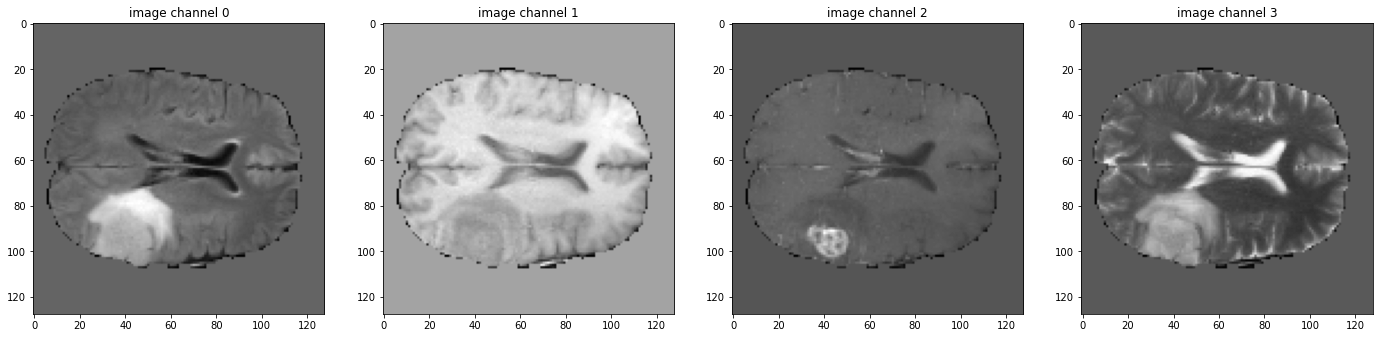

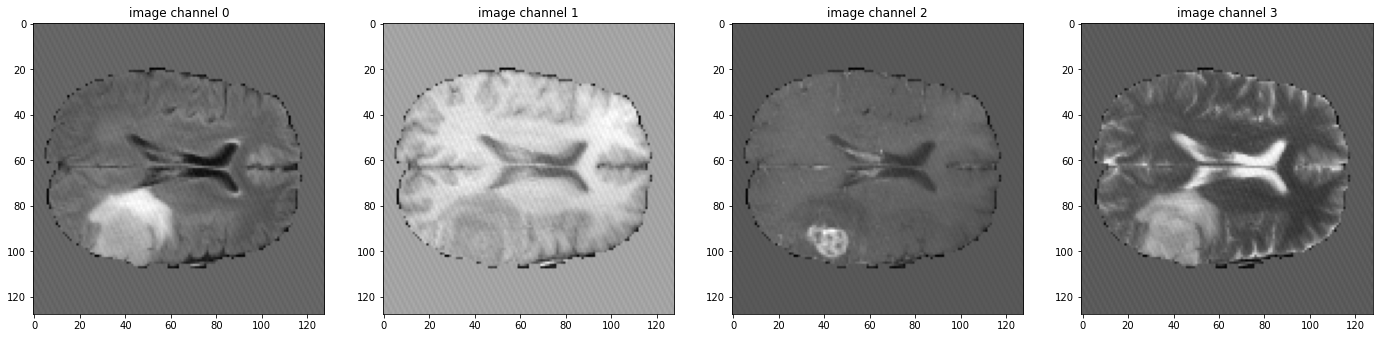

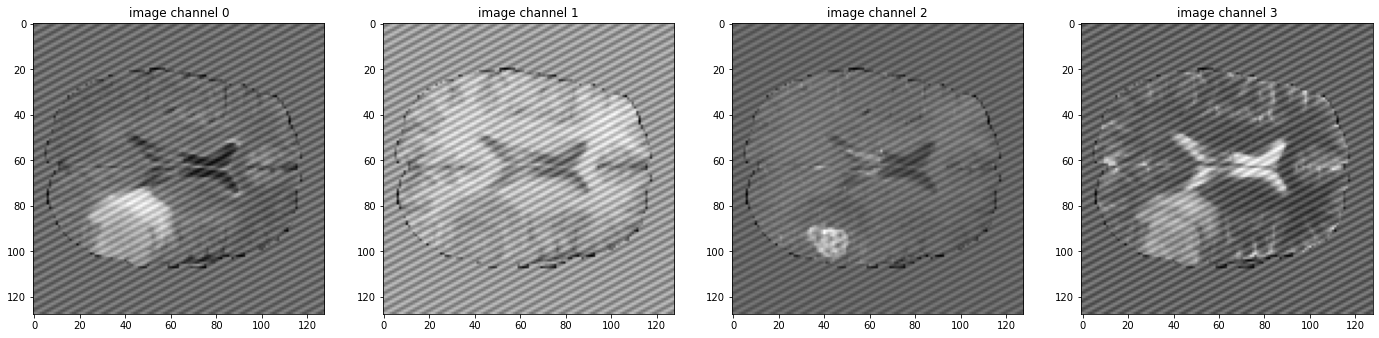

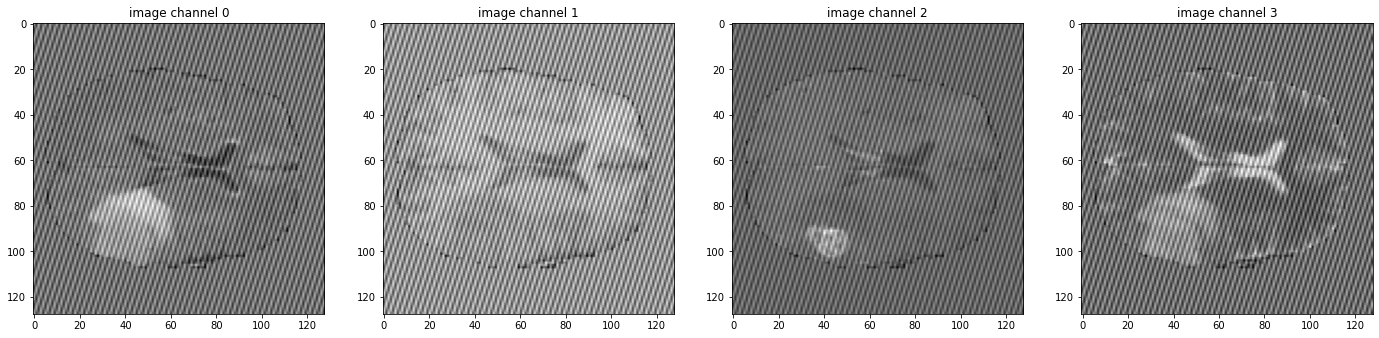

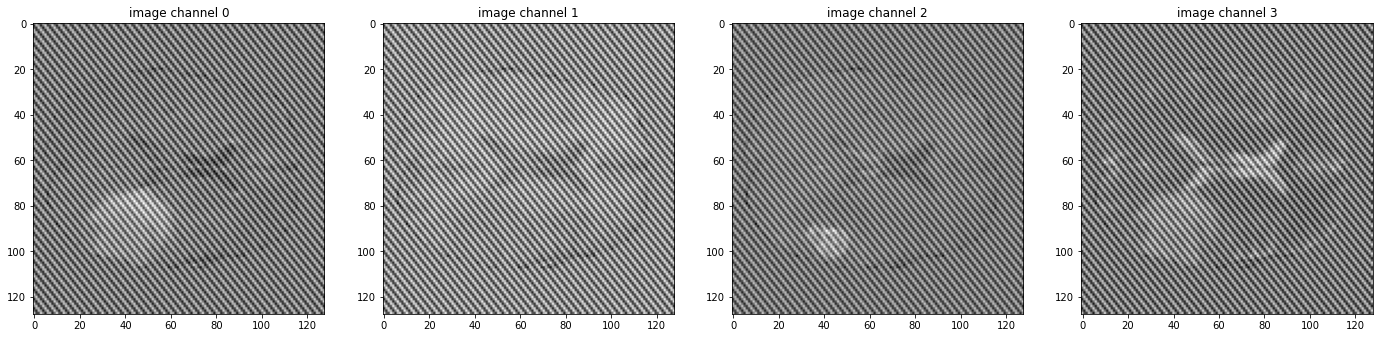

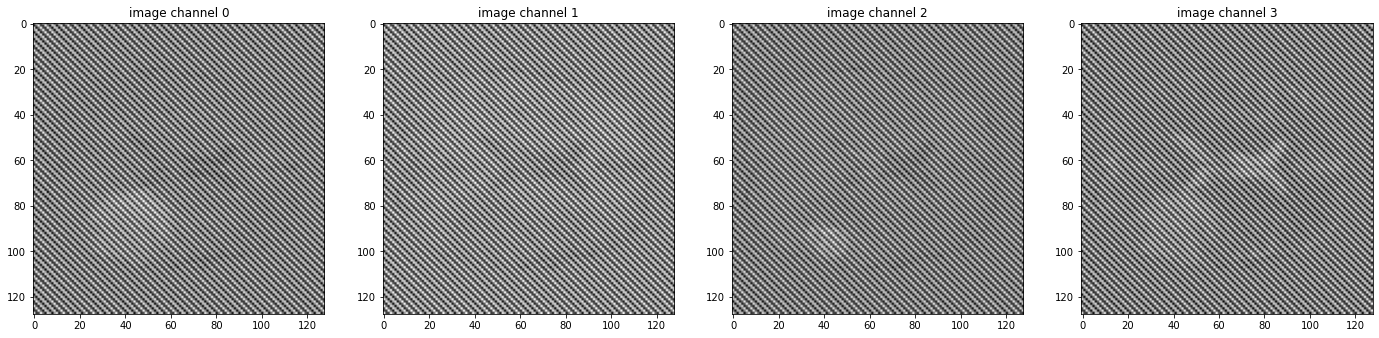

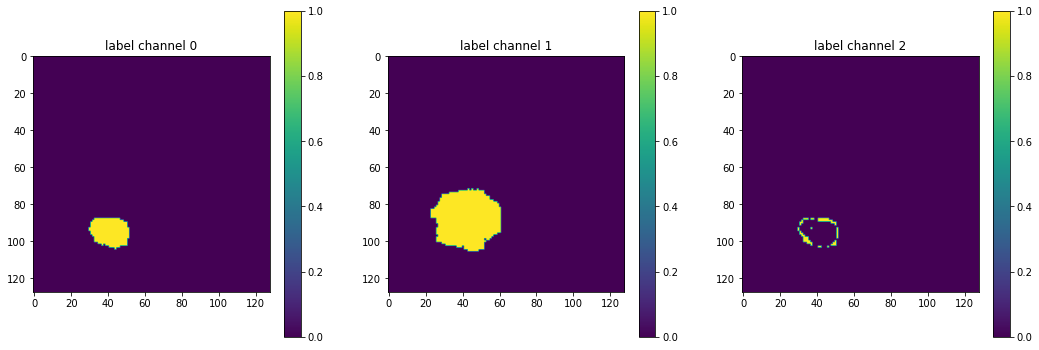

In [11]:
# pick one image from DecathlonDataset to visualize and check the 4 channels
img_base = test_ds_baseline[20]['image']
img_planes12 = test_ds_planes12[20]['image']
img_planes14 = test_ds_planes14[20]['image']
img_planes15 = test_ds_planes15[20]['image']
img_planes16 = test_ds_planes16[20]['image']
img_planes17 = test_ds_planes17[20]['image']
label = test_ds_baseline[20]['label']

print(f"image shape: {img_base.shape}")
plt.figure('baseline',(24, 6))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.title(f"image channel {i}")
    plt.imshow(img_base[i, :, :, 32].detach().cpu(), cmap="gray")
plt.show()

plt.figure('planes12',(24,6))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.title(f"image channel {i}")
    plt.imshow(img_planes12[i, :, :, 32].detach().cpu(), cmap="gray")
plt.show()

plt.figure('planes14',(24,6))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.title(f"image channel {i}")
    plt.imshow(img_planes14[i, :, :, 32].detach().cpu(), cmap="gray")
plt.show()

plt.figure('planes15',(24,6))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.title(f"image channel {i}")
    plt.imshow(img_planes15[i, :, :, 32].detach().cpu(), cmap="gray")
plt.show()

plt.figure('planes16',(24,6))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.title(f"image channel {i}")
    plt.imshow(img_planes16[i, :, :, 32].detach().cpu(), cmap="gray")
plt.show()

plt.figure('planes17',(24,6))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.title(f"image channel {i}")
    plt.imshow(img_planes17[i, :, :, 32].detach().cpu(), cmap="gray")
plt.show()

# also visualize the 3 channels label corresponding to this image
plt.figure("label", (18, 6))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.title(f"label channel {i}")
    plt.imshow(label[i, :, :, 32].detach().cpu())
    plt.colorbar()
plt.show()

# Inference

In [9]:
os.listdir(root_dir)

['Task01_BrainTumour',
 'best_metric_model_monai_data.pth',
 'best_metric_model_baseline.pth',
 'trainLoss_and_meanValScore_baseline.png',
 'meanValScore_per_label_baseline.png',
 'best_metric_model_Gibbs35.pth',
 'trainLoss_and_meanValScore_Gibbs35.png',
 'meanValScore_per_label_Gibbs35.png',
 'best_metric_model_Gibbs25.pth',
 'trainLoss_and_meanValScore_Gibbs25.png',
 'meanValScore_per_label_Gibbs25.png',
 'best_metric_model_Gibbs15.pth',
 'trainLoss_and_meanValScore_Gibbs15.png',
 'meanValScore_per_label_Gibbs15.png',
 'best_metric_model_Gibbs10.pth',
 'trainLoss_and_meanValScore_Gibbs10.png',
 'meanValScore_per_label_Gibbs10.png',
 'best_metric_model_Gibbs20.pth',
 'best_metric_model_Gibbs12.5.pth',
 'trainLoss_and_meanValScore_Gibbs12.5.png',
 'meanValScore_per_label_Gibbs12.5.png',
 'trainLoss_and_meanValScore_Gibbs20.png',
 'meanValScore_per_label_Gibbs20.png',
 'best_metric_model_Gibbs9.pth',
 'best_metric_model_Gibbs10-25.pth',
 'trainLoss_and_meanValScore_Gibbs9.png',
 'meanV

In [8]:
dice_metric = DiceMetric(include_background=True, reduction="mean")
post_trans = Compose([Activations(sigmoid=True),
                              AsDiscrete(threshold_values=True)])

In [60]:
from collections import defaultdict

class model_evaluation:
    '''Provides with regularly used tools
    
    Methods:
    
    * _load_UNet: loads instance of UNet model
    
    * dataset_eval: computes metrics on given dataset dataloader
    
    * add_eval: keeps record of metrics for given dataset
    
    '''
    
    def __init__(self, model_name:str, instance_name:str):
        
        '''
        Args:
            model_name = name of saved model.pth.
            instance_name = label for the class instantation
            
        '''
    
        self.model_name = model_name
        self.model = self._load_UNet(model_name)
        self.instance_name = instance_name
        self.eval_dict = defaultdict(list)
    
    
    def _load_UNet(self,model_name:str):
    
        '''Function to load model.
        Args: model_name = name of saved model.pth
        
        Returns: instance of UNet with imported weights'''

        model = UNet(dimensions=3, in_channels=4, out_channels=3, 
                     channels=(16, 32, 64, 128, 256), 
                     strides=(2, 2, 2, 2),
                     num_res_units=2,).to(device)
        model.load_state_dict(torch.load(root_dir+model_name))
        return model 
    
    
    def dataset_eval(self, test_loader:DataLoader):
        ''' To evaluate model on given data using Dice metric
        Args:
            test_data: test data loader
        Returns:
            mean metrics
        '''
        self.model.eval()
        with torch.no_grad():
            dice_metric = DiceMetric(include_background=True, reduction="mean")
            post_trans = Compose([Activations(sigmoid=True),
                                  AsDiscrete(threshold_values=True)])

            metric_sum = 0.
            metric_sum_tc = 0.
            metric_sum_wt = 0.
            metric_sum_et = 0.

            metric_count = 0
            metric_count_tc  = 0
            metric_count_wt = 0
            metric_count_et = 0

            for test_data in tqdm(test_loader):
                val_inputs, val_labels = (
                    test_data["image"].to(device),
                    test_data["label"].to(device),
                )
                val_outputs = self.model(val_inputs)
                val_outputs = post_trans(val_outputs)
                # compute overall mean dice
                value, not_nans = dice_metric(y_pred=val_outputs, y=val_labels)
                not_nans = not_nans.item()
                metric_count += not_nans
                metric_sum += value.item() * not_nans
                # compute mean dice for TC
                value_tc, not_nans = dice_metric(
                    y_pred=val_outputs[:, 0:1], y=val_labels[:, 0:1]
                )
                not_nans = not_nans.item()
                metric_count_tc += not_nans
                metric_sum_tc += value_tc.item() * not_nans
                # compute mean dice for WT
                value_wt, not_nans = dice_metric(
                    y_pred=val_outputs[:, 1:2], y=val_labels[:, 1:2]
                )
                not_nans = not_nans.item()
                metric_count_wt += not_nans
                metric_sum_wt += value_wt.item() * not_nans
                # compute mean dice for ET
                value_et, not_nans = dice_metric(
                    y_pred=val_outputs[:, 2:3], y=val_labels[:, 2:3]
                )
                not_nans = not_nans.item()
                metric_count_et += not_nans
                metric_sum_et += value_et.item() * not_nans

            metric = metric_sum / metric_count
            metric_tc = metric_sum_tc / metric_count_tc
            metric_wt = metric_sum_wt / metric_count_wt
            metric_et = metric_sum_et / metric_count_et

        return metric, metric_et, metric_tc, metric_wt

    def add_eval(self, name:str, test_loader:DataLoader, data_dict:dict=None) -> None:
        '''Method to add evaluation to the attribute
        eval_dict.
        
        Args: 
            name = string to label evaluation
            test_loader = dataloader of data to test 
            data_dict = dictionary of type {name:test_loader}. If this argument is
                        passed, the other arguments are ignored.
        '''
        
        if data_dict == None:
            self.eval_dict[name] = self.dataset_eval(test_loader)
        else:
            for name in data_dict:
                self.eval_dict[name] = self.dataset_eval(data_dict[name])
                
    def save(self):
        '''save a the state the dictionary in a pickle'''
        with open(self.instance_name+'.pickle', 'wb') as f:
            pickle.dump(self.__dict__, f)
            
    def load_dict(self, filename:str):
        '''load instance of class'''
        with open(filename, 'rb') as f:
            self.__dict__.update(pickle.load(f))

## Check models' output with the input image and label

In [16]:
baseline.model.eval()
with torch.no_grad():
    # select one image to evaluate and visualize the model output
    val_input = img_base.unsqueeze(0).to(device)
    val_output = baseline.model(val_input)
    plt.figure("image", (24, 6))
    for i in range(4):
        plt.subplot(1, 4, i + 1)
        plt.title(f"image channel {i}")
        plt.imshow(img_base[i, :, :, 32].detach().cpu(), cmap="gray")
    plt.show()
    # visualize the 3 channels label corresponding to this image
    plt.figure("label", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"label channel {i}")
        plt.imshow(label[i, :, :, 32].detach().cpu())
        plt.colorbar()
    plt.show()
    # visualize the 3 channels model output corresponding to this image
    plt.figure("baseline", (18, 6))
    plt.suptitle('Baseline model prediction on baseline data')
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"output channel {i}")
        plt.imshow(torch.sigmoid(val_output[0, i, :, :, 32].detach().cpu()))
        plt.colorbar()
    plt.show()
    
    # Gibbs15 model/data 
    gibbs15.model.eval()
    val_input = img_gibbs15.unsqueeze(0).to(device)
    val_output = gibbs15.model(val_input)
    plt.figure("gibbs15", (18, 6))
    plt.suptitle('Gibbs15 model prediction on Gibbs15 data')
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"output channel {i}")
        plt.imshow(torch.sigmoid(val_output[0, i, :, :, 32].detach().cpu()))
        plt.colorbar()
    plt.show()

NameError: name 'baseline' is not defined

## Model comparisons

In [13]:
baseline = model_evaluation('best_metric_model_baseline.pth', 'baseline model')
baseline.add_eval('baseline_data', test_loader_baseline)
baseline.add_eval('planes12_data', test_loader_planes12)
baseline.add_eval('planes14_data', test_loader_planes14)
baseline.add_eval('planes15_data', test_loader_planes15)
baseline.add_eval('planes16_data', test_loader_planes16)
baseline.add_eval('planes16.5_data', test_loader_planes16p5)
baseline.add_eval('planes17_data', test_loader_planes17)

100%|██████████| 24/24 [00:27<00:00,  1.16s/it]


In [ ]:
baseline.eval_dict

In [21]:
planes12 = model_evaluation('best_metric_model_planes_a55.0b55.0c30.0_int12.0.pth', 'Planes12 model')
planes12.add_eval('baseline_data', test_loader_baseline)
planes12.add_eval('planes12_data', test_loader_planes12)
planes12.add_eval('planes14_data', test_loader_planes14)
planes12.add_eval('planes15_data', test_loader_planes15)
planes12.add_eval('planes16_data', test_loader_planes16)
planes12.add_eval('planes16.5_data', test_loader_planes16p5)
planes12.add_eval('planes17_data', test_loader_planes17)

100%|██████████| 24/24 [00:26<00:00,  1.12s/it]


In [22]:
planes14 = model_evaluation('best_metric_model_planes_a55.0b55.0c30.0_int14.0.pth', 'Planes14 model')
planes14.add_eval('baseline_data', test_loader_baseline)
planes14.add_eval('planes12_data', test_loader_planes12)
planes14.add_eval('planes14_data', test_loader_planes14)
planes14.add_eval('planes15_data', test_loader_planes15)
planes14.add_eval('planes16_data', test_loader_planes16)
planes14.add_eval('planes16.5_data', test_loader_planes16p5)
planes14.add_eval('planes17_data', test_loader_planes17)

100%|██████████| 24/24 [00:25<00:00,  1.07s/it]


In [14]:
planes15 = model_evaluation('best_metric_model_planes_a55.0b55.0c30.0_int15.0.pth', 'Planes15 model')
planes15.add_eval('baseline_data', test_loader_baseline)
planes15.add_eval('planes12_data', test_loader_planes12)
planes15.add_eval('planes14_data', test_loader_planes14)
planes15.add_eval('planes15_data', test_loader_planes15)
planes15.add_eval('planes16_data', test_loader_planes16)
planes15.add_eval('planes16.5_data', test_loader_planes16p5)
planes15.add_eval('planes17_data', test_loader_planes17)

100%|██████████| 24/24 [00:31<00:00,  1.30s/it]


In [15]:
planes16 = model_evaluation('best_metric_model_planes_a55.0b55.0c30.0_int16.0.pth', 'Planes16 model')
planes16.add_eval('baseline_data', test_loader_baseline)
planes16.add_eval('planes12_data', test_loader_planes12)
planes16.add_eval('planes14_data', test_loader_planes14)
planes16.add_eval('planes15_data', test_loader_planes15)
planes16.add_eval('planes16_data', test_loader_planes16)
planes16.add_eval('planes16.5_data', test_loader_planes16p5)
planes16.add_eval('planes17_data', test_loader_planes17)

100%|██████████| 24/24 [00:32<00:00,  1.36s/it]


In [16]:
planes16p5 = model_evaluation('best_metric_model_planes_a55.0b55.0c30.0_int16.5.pth', 'Planes16.5 model')
planes16p5.add_eval('baseline_data', test_loader_baseline)
planes16p5.add_eval('planes12_data', test_loader_planes12)
planes16p5.add_eval('planes14_data', test_loader_planes14)
planes16p5.add_eval('planes15_data', test_loader_planes15)
planes16p5.add_eval('planes16_data', test_loader_planes16)
planes16p5.add_eval('planes16.5_data', test_loader_planes16p5)
planes16p5.add_eval('planes17_data', test_loader_planes17)

100%|██████████| 24/24 [00:27<00:00,  1.13s/it]


In [17]:
planes17 = model_evaluation('best_metric_model_planes_a55.0b55.0c30.0_int17.0.pth', 'Planes17 model')
planes17.add_eval('baseline_data', test_loader_baseline)
planes17.add_eval('planes12_data', test_loader_planes12)
planes17.add_eval('planes14_data', test_loader_planes14)
planes17.add_eval('planes15_data', test_loader_planes15)
planes17.add_eval('planes16_data', test_loader_planes16)
planes17.add_eval('planes16.5_data', test_loader_planes16p5)
planes17.add_eval('planes17_data', test_loader_planes17)

100%|██████████| 24/24 [00:31<00:00,  1.29s/it]


In [45]:
def plot_model_performance(gibbs_values:list, model_evals:list, metric:str, figsize:tuple = None, xlim:tuple=None, ylim:tuple=None):
    '''
    Plots each model's performance over a range of stylized 
    datasets.
    
    Args: 
        gibbs_values = list of Gibbs values associated with each
            test dataset.
        model_evals = instances of the model_evaluation class
            for each model to evaluate.
        metric = one of [mean, et, tc, wt].
    '''
    metrics_map ={'mean':0, 'et':1, 'tc':2, 'wt':3}
    keys = model_evals[0].eval_dict.keys()
    plt.figure(figsize=figsize)
    for model in model_evals:
        vals = []
        for k in keys:
            vals.append(dict(model.eval_dict)[k][metrics_map[metric]])
        plt.plot(gibbs_values,list(vals),'-*',label=model.instance_name)
    plt.legend()
    plt.xlabel('Planar noise stylized test data')
    plt.title(metric+' Dice score for each planar-stylized model')
    if xlim:
        plt.xlim(*xlim)
    if ylim:
        plt.ylim(*ylim)
    plt.show()
    

In [19]:
baseline.eval_dict

defaultdict(list,
            {'baseline_data': (0.7432693392038345,
              0.5489715797205766,
              0.7797949202358723,
              0.9010415002703667),
             'planes12_data': (0.7379889140526453,
              0.5450547337532043,
              0.7731041597823302,
              0.8958078597982725),
             'planes14_data': (0.6532334014773369,
              0.4606471930940946,
              0.6829871746400992,
              0.8160658155878385),
             'planes15_data': (0.6030049920082092,
              0.39411539987971383,
              0.6309765527645746,
              0.7839230298995972),
             'planes16_data': (0.24736921985944113,
              0.08873829470636944,
              0.21257316949777305,
              0.4407961970816056),
             'planes16.5_data': (0.06040851833919684,
              0.0118344196647134,
              0.038596305835502186,
              0.1307948298441867),
             'planes17_data': (0.0134574228626055

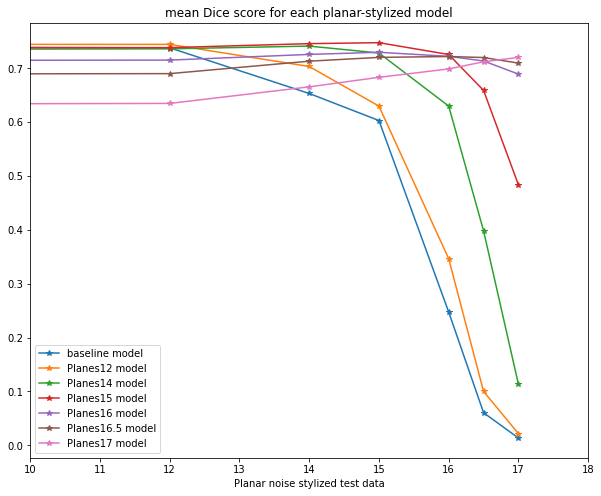

In [48]:
plot_model_performance([0, 12,14,15,16,16.5,17],[baseline,planes12, planes14, planes15, planes16, planes16p5, planes17],'mean', figsize=(10,8), xlim=(10,18))

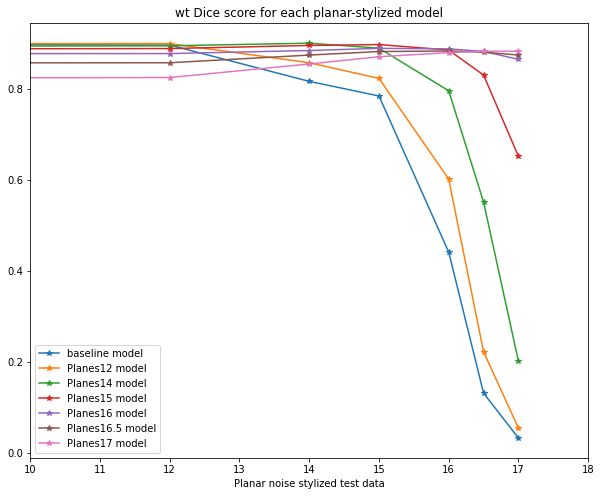

In [47]:
plot_model_performance([0, 12,14,15,16,16.5, 17],[baseline,planes12, planes14, planes15, planes16, planes16p5,planes17],'wt',figsize=(10,8), xlim= (10,18))

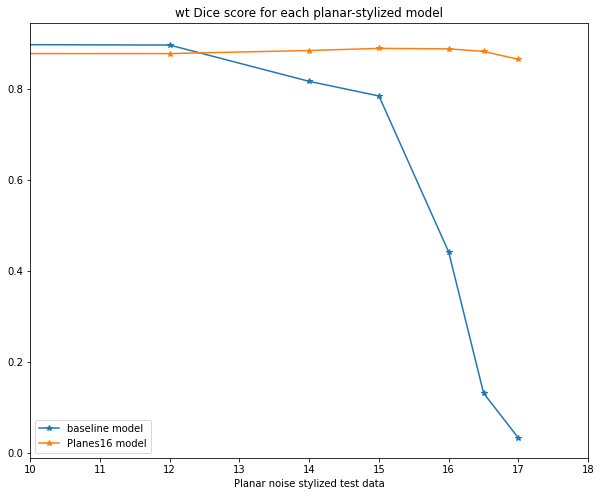

In [49]:
plot_model_performance([0, 12,14,15,16,16.5, 17],[baseline, planes16],'wt',figsize=(10,8), xlim= (10,18))

In [24]:
def plot_model_performance_(gibbs_values:list, model_evals:list, metric:str):
    '''
    Args: 
        metric = one of [mean, et, tc, wt]
    '''
    metrics_map ={'mean':0, 'et':1, 'tc':2, 'wt':3}
    keys = model_evals[0].eval_dict.keys()
    print(keys)
#     [print(type(model.eval_dict)) for model in model_evals]
    plt.figure(figsize=(7,7)) 
    for k in keys:
        vals_at_dataset = []
        for model in model_evals:
            vals_at_dataset.append(dict(model.eval_dict)[k][metrics_map[metric]])
        plt.plot(gibbs_values,list(vals_at_dataset), label='test '+k)
    plt.legend()
    plt.xlabel('Gibbs stylized models')
    plt.title(metric+' Dice score for each test dataset')
#     plt.ylim(.8,.9)
    plt.show()

dict_keys(['baseline_data', 'planes12_data', 'planes14_data', 'planes15_data'])


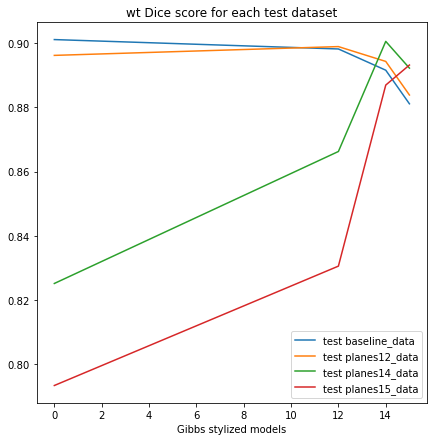

In [25]:
plot_model_performance_([0, 12,14,15],[baseline,planes12, planes14,planes15],'wt')

In [57]:
baseline_x = model_evaluation('best_metric_model_baseline.pth', 'baseline model')
baseline_x.add_eval('baseline_data', test_loader_baseline)
baseline_x.add_eval('planes12_data', test_loader_planes12)

100%|██████████| 24/24 [00:23<00:00,  1.00it/s]


In [58]:
baseline_x.save()

In [53]:
import pickle

In [61]:
baseline_y = model_evaluation('best_metric_model_baseline.pth', 'baseline model')

In [62]:
baseline_y.load_dict('best_metric_model_baseline.pth.pickle')

In [64]:
baseline_y.

UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv3d(4, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): InstanceNorm3d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): InstanceNorm3d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
      )
      (residual): Conv3d(4, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Se